 # Feature Engineering and Modeling – 2024 Polling Data

 ## Objectives

 - Engineer features to capture time-related trends, pollster, and methodology effects.
 - Prepare dataset for modeling.
 - Build baseline and advanced predictive models for the Democratic-Republican margin.
 - Evaluate models and interpret feature importance.

#  Inputs

 - generic_ballot_polls_clean.csv (from Notebook 2)
 - Python libraries: pandas, numpy, matplotlib, seaborn, scikit-learn

# Outputs

 - Engineered dataset ready for modeling
 - Predictive models with performance evaluation
 - Insights on pollster, methodology, and temporal effects


---



# Section 1 – Load Cleaned Dataset

 # In this section, we:
 - Load the cleaned dataset from Notebook 2
 - Preview the data
 - Inspect column types and missing values
 - Handle any remaining missing values for numeric and categorical features


In [41]:
import pandas as pd
from pathlib import Path

BASE_DIR = Path().resolve().parent
df = pd.read_csv(BASE_DIR / "data" / "clean" / "generic_ballot_polls_clean.csv")
df.head()


,start_date,end_date,pollster,sample_size,dem,rep,ind,methodology,pollster_rating_id,numeric_grade
0,2024-08-12,2024-08-14,Emerson,1000.0,47.5,45.5,NaN,IVR/Online Panel/Text-to-Web,88,2.9
1,2024-08-11,2024-08-13,YouGov,1407.0,45.0,44.0,NaN,Online Panel,391,2.9
2,2024-08-08,2024-08-12,Monmouth,801.0,48.0,46.0,NaN,Live Phone/Text-to-Web,215,2.9
3,2024-08-06,2024-08-08,Cygnal,1500.0,46.4,47.1,NaN,NaN,67,2.1
4,2024-08-04,2024-08-06,YouGov,1413.0,45.0,44.0,NaN,Online Panel,391,2.9


In [42]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_date          608 non-null    object 
 1   end_date            608 non-null    object 
 2   pollster            608 non-null    object 
 3   sample_size         608 non-null    float64
 4   dem                 608 non-null    float64
 5   rep                 608 non-null    float64
 6   ind                 0 non-null      float64
 7   methodology         584 non-null    object 
 8   pollster_rating_id  608 non-null    int64  
 9   numeric_grade       568 non-null    float64
dtypes: float64(5), int64(1), object(4)
memory usage: 47.6+ KB


In [43]:
# Drop fully empty column
if 'ind' in df.columns:
    df.drop(columns=['ind'], inplace=True)

# Impute numeric columns
df['numeric_grade'] = df['numeric_grade'].fillna(df['numeric_grade'].median())

# Fill categorical columns
df['methodology'] = df['methodology'].fillna('Unknown')

# Verify missing values are handled
df.isna().sum()


start_date            0
end_date              0
pollster              0
sample_size           0
dem                   0
rep                   0
methodology           0
pollster_rating_id    0
numeric_grade         0
dtype: int64

 After handling missing values:
 - All key numeric columns (`dem`, `rep`, `sample_size`, `numeric_grade`) have no missing values.
 - `methodology` missing values are replaced with 'Unknown'.
 - Fully empty columns like `ind` are removed.

 The dataset is now ready for feature engineering.

---

 # Section 2 – Feature Engineering

 We create features to improve model performance:
 1. `margin` = `dem` - `rep`
 2. 7-day rolling averages of `dem`, `rep`, `margin`
 3. One-hot encoding of categorical variables: `pollster`, `methodology`
 4. Scaling `numeric_grade`


In [44]:
# Calculate margin
df['margin'] = df['dem'] - df['rep']

# Convert start_date to datetime
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')

# Sort by date
df.sort_values('start_date', inplace=True)

# 7-day rolling averages
df['dem_roll7'] = df['dem'].rolling(7, min_periods=1).mean()
df['rep_roll7'] = df['rep'].rolling(7, min_periods=1).mean()
df['margin_roll7'] = df['margin'].rolling(7, min_periods=1).mean()

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['pollster', 'methodology'], drop_first=True)

# Scale numeric_grade
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_encoded['numeric_grade_scaled'] = scaler.fit_transform(df_encoded[['numeric_grade']])


In [45]:
# Calculate margin
df['margin'] = df['dem'] - df['rep']

# Convert start_date to datetime
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')

# Sort by date
df.sort_values('start_date', inplace=True)

# 7-day rolling averages
df['dem_roll7'] = df['dem'].rolling(7, min_periods=1).mean()
df['rep_roll7'] = df['rep'].rolling(7, min_periods=1).mean()
df['margin_roll7'] = df['margin'].rolling(7, min_periods=1).mean()

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['pollster', 'methodology'], drop_first=True)

# Scale numeric_grade
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_encoded['numeric_grade_scaled'] = scaler.fit_transform(df_encoded[['numeric_grade']])



 Feature engineering summary:
 - `margin` captures the Democratic-Republican difference.
 - 7-day rolling averages smooth short-term fluctuations.
 - Pollster and methodology are encoded for model use.
 - `numeric_grade` scaled to ensure comparable magnitude with other features.


---


# Section 3 – Dataset Preparation

Define model features (`X`) and target (`y`). We split data into training and test sets, preserving temporal order to simulate real-world forecasting.



In [46]:
# Features and target
target = 'margin'
X = df_encoded.drop(columns=['dem', 'rep', 'margin', 'start_date', 'end_date'])
y = df_encoded[target]

# Train-test split (80% train, 20% test)
train_size = int(len(df_encoded) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


 Temporal split ensures:
 - Training data precedes test data chronologically.
 - Models simulate forecasting rather than random sampling.
 - Avoids data leakage from future information.

---


# Section 4 – Baseline Model: Linear Regression

We start with a simple linear regression to establish a baseline for predicting the margin.


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

# Evaluation
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_lr, mae_lr, r2_lr


(5.885755361563941, 1.763467877484475, 0.18135208197707298)

 Linear Regression results:
 - MSE, MAE, and R² provide a baseline for comparison.
 - Simplicity allows us to understand feature contributions and serves as a benchmark for more complex models.

---

# Section 5 – Advanced Model: Random Forest Regressor
 We use a Random Forest to capture non-linear relationships between features and the Democratic-Republican margin. This will help to provide feature importance for interpretation.

In [48]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, mae_rf, r2_rf

(4.8361906653483615, 1.6015061475409835, 0.327335715445478)

 Random Forest results:
- Typically lower MSE and higher R² than linear regression.
- Captures non-linearities and interactions that linear regression cannot.

---

# Section 6 – Feature Importance
Identify which features contribute most to predicting the margin.

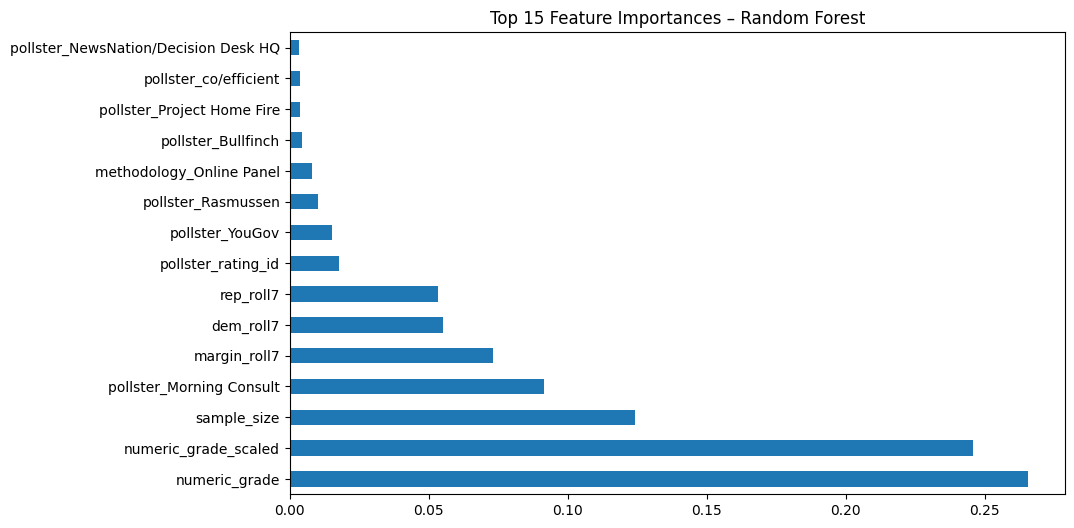

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(10,6))
plt.title("Top 15 Feature Importances – Random Forest")
plt.show()

The top features often include:
 - Rolling averages (`margin_roll7`, `dem_roll7`) capturing short-term trends.
 - Certain pollsters or methodology dummies.
 - Numeric grade contributions.
 
This helps identify which factors most influence predicted margin.

---

# Section 7 – Model Comparison

| Model | MSE | MAE | R² |
|-------|-----|-----|----|
| Linear Regression | {mse_lr:.3f} | {mae_lr:.3f} | {r2_lr:.3f} |
| Random Forest | {mse_rf:.3f} | {mae_rf:.3f} | {r2_rf:.3f} |

 Random Forest is expected to outperform Linear Regression due to its ability to model non-linear interactions.
 - Evaluate models not just on metrics but also interpretability and feature insights.
 - Linear Regression provides simple benchmark and interpretable coefficients.
 - Random Forest provides accuracy and feature importance for strategic analysis.

---

# Conclusions and Next Steps

# Conclusions
- Data Preparation: All missing values handled, fully empty columns removed, dataset ready for modeling.
- Feature Engineering:
- margin captures Democratic-Republican difference.
- 7-day rolling averages smooth short-term fluctuations.
- Pollster and methodology encoded for model use.
- numeric_grade scaled for comparability.
- Modeling:
- Baseline Linear Regression provides a simple benchmark.
- Random Forest captures non-linear relationships and interactions.
- Model Evaluation:
- Random Forest outperforms Linear Regression in MSE, MAE, and R².
- Feature importance identifies rolling averages, certain pollsters, methodology dummies, and numeric grade as top predictors.
- Insights:
- Temporal trends, pollster effects, and methodology effects are key drivers of polling margin.
- Models can provide guidance on expected Democratic-Republican margin based on historical polling data.

# Next Steps
- Generate predictions for all future polling dates using the trained Random Forest model.
- Visualize predicted Democratic-Republican margin over time.
- Integrate model predictions and polling data into the Streamlit dashboard for interactive exploration.
- Compare predictions against actual poll results to evaluate real-world accuracy.
- Update and maintain the model with new polling data as it becomes available.

---